In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time, os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import re 
import string
from textblob import TextBlob
from nltk.tokenize import sent_tokenize,word_tokenize,MWETokenizer, RegexpTokenizer
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer,WordNetLemmatizer
from gensim import corpora, models, similarities, matutils
from corextopic import corextopic as ct
import seaborn as sns

/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
new_reviews = pd.read_csv('preprocessed_reviews.csv')
new_reviews.drop('Unnamed: 0',axis=1,inplace=True)
new_reviews.head()

,review
0,shang_chi review spectacular visual wonder my ...
1,the much await change chi and the legend of th...
2,like many I be concerned that this new marvel ...
3,no movie be without flaw but this be a breath ...
4,hand down one of the good you move every actor...


In [3]:
#CountVectorizer

reviews_series=new_reviews.review

vectorizer = CountVectorizer(stop_words='english',max_df=.1,ngram_range=(1,2))
doc_word = vectorizer.fit_transform(reviews_series)


doc_term=pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())

doc_term.head()

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaawwwwssssoooommmeeee,abbe,abc,abc american,abc movie,ability,ability comic,ability continue,ability fearlessly,...,zero,zero feel,zero foul,zheg,zone,zone marvel,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,生者如斯,逝者安息,逝者安息 生者如斯
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### LSA Model

In [4]:
#LSA Model
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.02268704, 0.01086508, 0.00918322, 0.0085867 , 0.00846   ])

In [5]:
#create topic word matrix
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2",'component_3','component_4','componnt_5'], #,'component_4','componnt_5'
             columns = vectorizer.get_feature_names())
topic_word

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaawwwwssssoooommmeeee,abbe,abc,abc american,abc movie,ability,ability comic,ability continue,ability fearlessly,...,zero,zero feel,zero foul,zheg,zone,zone marvel,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,生者如斯,逝者安息,逝者安息 生者如斯
component_1,0.0,0.0,0.0,0.001,0.000,0.000,0.009,0.000,0.000,0.001,...,0.005,0.004,0.001,0.000,0.0,0.0,0.0,0.0,0.0,0.0
component_2,-0.0,-0.0,-0.0,-0.001,-0.000,-0.001,0.001,-0.000,-0.000,0.002,...,-0.003,-0.004,0.001,0.000,0.0,0.0,0.0,-0.0,-0.0,-0.0
component_3,-0.0,-0.0,-0.0,-0.000,0.001,-0.001,-0.026,0.001,-0.000,-0.001,...,0.027,0.027,-0.000,-0.000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_4,-0.0,-0.0,-0.0,0.001,0.000,0.001,0.004,0.000,0.001,-0.000,...,-0.006,-0.006,-0.000,0.001,-0.0,-0.0,-0.0,0.0,0.0,0.0
componnt_5,0.0,-0.0,0.0,-0.000,0.000,-0.001,-0.022,-0.001,-0.001,0.001,...,-0.001,-0.001,-0.000,-0.001,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


In [6]:
#function to display top words in topics

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
        
#display top words

display_topics(lsa, vectorizer.get_feature_names(), 20)


Topic  0
make, really, feel, time, ring, asia, fight scene, art, long, martial, way, think, new, martial art, chi, end, bad, culture, actor, come

Topic  1
sequence, long, ring, world, art, tony_leung, simu_liu, legend, wonderful, action sequence, actor, new, legend ring, stand, performance, cinema, martial art, martial, mitchell, add

Topic  2
asia, way, feel, dad, sum, culture, didn, bit, feel like, death, bad, development, character development, asia culture, chinese, ring, long, representation, plot, think

Topic  3
make, time, bad, father, end, score, flashback, plot, year, try, high, tell, explain, power, background, use, fun, background score, extraordinary, don

Topic  4
feel, really, visual, score, worth, extraordinary, cast, background, background score, bring, awesome, superhero, high, time, style, definitely, sound, fantastic, cinematography, notch


### NMF Model

In [7]:
#vectorizer

vectorizer = CountVectorizer(stop_words='english',max_df=.1,ngram_range=(1,2))
doc_word_nmf = vectorizer.fit_transform(reviews_series)

doc_word_nmf


<2206x22343 sparse matrix of type '<class 'numpy.int64'>'
	with 49241 stored elements in Compressed Sparse Row format>

In [8]:
#intialize model 

nmf_model = NMF(5)
doc_topic_NMF = nmf_model.fit_transform(doc_word_nmf)
doc_topic_NMF.shape

/Users/nickpondok/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(2206, 5)

In [9]:
nmf_model.components_.shape

(5, 22343)

In [10]:
doc_topic_df=pd.DataFrame(doc_topic_NMF)
doc_topic_df

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,4.876512
1,0.000000,4.850770,0.000000,0.000000,0.000000
2,0.791422,0.045484,0.129428,0.000000,0.000000
3,0.000000,0.000000,0.049984,1.098833,0.000000
4,1.154882,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2201,0.000000,0.000000,0.000000,0.000000,0.000000
2202,0.000000,0.000000,0.009223,0.001476,0.000000
2203,0.000000,0.000000,0.000000,0.000000,0.000000
2204,0.003917,0.000000,0.008876,0.013418,0.000000


In [11]:
def get_max(row):
    max_idx=row.argmax()
    return max_idx



new_series = doc_topic_df.idxmax(axis=1)
doc_topic_df['topic']=new_series
doc_topic_df

,0,1,2,3,4,topic
0,0.000000,0.000000,0.000000,0.000000,4.876512,4
1,0.000000,4.850770,0.000000,0.000000,0.000000,1
2,0.791422,0.045484,0.129428,0.000000,0.000000,0
3,0.000000,0.000000,0.049984,1.098833,0.000000,3
4,1.154882,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...
2201,0.000000,0.000000,0.000000,0.000000,0.000000,0
2202,0.000000,0.000000,0.009223,0.001476,0.000000,2
2203,0.000000,0.000000,0.000000,0.000000,0.000000,0
2204,0.003917,0.000000,0.008876,0.013418,0.000000,3


In [12]:
#topic word matrix

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2",'component_3','compenent_4','compenent_5'], #,'compenent_4','compenent_5'
             columns = vectorizer.get_feature_names())
topic_word_nmf

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaawwwwssssoooommmeeee,abbe,abc,abc american,abc movie,ability,ability comic,ability continue,ability fearlessly,...,zero,zero feel,zero foul,zheg,zone,zone marvel,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,生者如斯,逝者安息,逝者安息 生者如斯
component_1,0.001,0.0,0.0,0.003,0.003,0.001,0.053,0.000,0.000,0.004,...,0.000,0.000,0.004,0.000,0.001,0.001,0.0,0.001,0.001,0.001
component_2,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.001,0.000,0.005,...,0.000,0.000,0.006,0.000,0.001,0.001,0.0,0.000,0.000,0.000
component_3,0.000,0.0,0.0,0.000,0.001,0.000,0.000,0.001,0.000,0.000,...,0.134,0.134,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
compenent_4,0.000,0.0,0.0,0.008,0.001,0.007,0.059,0.004,0.005,0.000,...,0.000,0.000,0.000,0.007,0.000,0.000,0.0,0.001,0.001,0.001
compenent_5,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.008,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000


In [13]:
#get top words

display_topics(nmf_model, vectorizer.get_feature_names(), 20)


Topic  0
really, feel, art, martial, martial art, fight scene, definitely, awesome, fighting, enjoy, new, think, lot, marvel movie, feel like, choreography, chi, visual, act, funny

Topic  1
sequence, long, ring, world, legend, wonderful, new, tony_leung, stand, simu_liu, legend ring, chi, actor, action sequence, chinese, way, art, phase, cinema, makarin

Topic  2
asia, way, culture, dad, feel, representation, sum, didn, asia culture, bit, man, death, character development, development, think, cast, overall, year, come, plot

Topic  3
make, bad, plot, end, time, father, use, ring, fight scene, try, tell, think, flashback, explain, place, say, come, year, thing, didn

Topic  4
time, score, world, background, high, visual, background score, extraordinary, cast, performance, worth, superhero, actor, bring, don, cinematography, style, power, make, seat


### LDA Model

In [14]:
#Vectorizer 

vectorizer = CountVectorizer(stop_words='english',max_df=.1,ngram_range=(1,2))
doc_word_lda = vectorizer.fit_transform(reviews_series)

In [15]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word_lda)

In [16]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
len(id2word)

22343

In [17]:
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10)


In [18]:
lda.print_topics()

[(0,
  '0.014*"ability project" + 0.010*"able know" + 0.009*"action fight" + 0.009*"actually bad" + 0.009*"actor like" + 0.008*"acting incredible" + 0.008*"act effectively" + 0.008*"absolutely" + 0.007*"absolutely kill" + 0.007*"act character"'),
 (1,
  '0.022*"able akwafinas" + 0.021*"able connect" + 0.018*"beautiful costing" + 0.018*"abbe" + 0.016*"ability movie" + 0.015*"able" + 0.014*"acting awkward" + 0.013*"absolutely stunning" + 0.012*"absolutely perfect" + 0.012*"act single"'),
 (2,
  '0.021*"absolute delight" + 0.019*"absolutely brilliantly" + 0.018*"abc" + 0.016*"abundant ton" + 0.014*"act beautiful" + 0.013*"absolute joy" + 0.012*"accept right" + 0.011*"act love" + 0.011*"action didn" + 0.011*"ability continue"'),
 (3,
  '0.035*"aaaaawwwwssssoooommmeeee" + 0.027*"able control" + 0.014*"acting amazing" + 0.013*"able read" + 0.012*"act slow" + 0.012*"action chi" + 0.010*"act awesome" + 0.010*"absolutely dynamic" + 0.009*"action engage" + 0.009*"able law"'),
 (4,
  '0.032*"aaaa

In [19]:
lda_corpus = lda[corpus]
lda_corpus

In [20]:
lda_docs = [doc for doc in lda_corpus]

lda_docs

[[(0, 0.10063779),
  (1, 0.10064585),
  (2, 0.10064439),
  (3, 0.5974253),
  (4, 0.10064667)],
 [(0, 0.10021728),
  (1, 0.10022084),
  (2, 0.10021892),
  (3, 0.599124),
  (4, 0.1002189)],
 [(0, 0.100034475),
  (1, 0.10003469),
  (2, 0.10003503),
  (3, 0.59986115),
  (4, 0.10003469)],
 [(0, 0.0666775),
  (1, 0.06667762),
  (2, 0.0666776),
  (3, 0.39998427),
  (4, 0.39998305)],
 [(0, 0.100007355),
  (1, 0.10000745),
  (2, 0.100007445),
  (3, 0.100007445),
  (4, 0.59997034)],
 [(0, 0.100007534),
  (1, 0.10000762),
  (2, 0.1000076),
  (3, 0.5999697),
  (4, 0.100007586)],
 [(0, 0.025005588),
  (1, 0.025005631),
  (2, 0.5253384),
  (3, 0.14961171),
  (4, 0.27503866)],
 [(0, 0.10000666),
  (1, 0.10000673),
  (2, 0.59997314),
  (3, 0.10000675),
  (4, 0.10000668)],
 [(0, 0.100012146),
  (1, 0.10001224),
  (2, 0.100012265),
  (3, 0.5999512),
  (4, 0.10001219)],
 [(0, 0.10000114),
  (1, 0.10000117),
  (2, 0.5999954),
  (3, 0.10000117),
  (4, 0.10000114)],
 [(0, 0.10000077),
  (1, 0.10000078),
  (

In [21]:
len(lda_docs)

22343

### Corex Model

In [22]:
!pip install corextopic
!pip install networkx

In [23]:
#Vectorizer 

vectorizer_corex = CountVectorizer(stop_words='english',max_df=.8,ngram_range=(1,1),binary=True)
doc_word_corex = vectorizer_corex.fit_transform(reviews_series)
words_corex=list(np.asarray(vectorizer_corex.get_feature_names()))

In [24]:
corex_top_model=ct.Corex(n_hidden=4, words=words_corex, seed=1)
corex_top_model.fit(doc_word_corex, words=words_corex,anchors=['story','culture','martial','cast'], docs=new_reviews.review)

#,anchors=['story','culture','martial','cast']

In [25]:
topics_corex = corex_top_model.get_topics()
for n,topic in enumerate(topics_corex):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
#Topic 0 = story line, fighting scene
#Topic 1 = Asian culture 
#Topic 2 = Martial Arts and Fantasy 
#Topic 3 = Cast i.e awkwafina, simu_liu tony_leung

0: scene,story,fight,action,great,visual,effect,film,humor,credit
1: culture,asia,make,chinese,king,ff,people,marvel,american,especially
2: like,character,shang_chi,martial,art,villain,awkwafina,think,ring,come
3: feel,just,way,really,time,don,review,watch,simu_liu,cast


In [109]:
corex_top_model.tc

6.300563326546238

In [110]:
corex_top_model.tcs

array([1.04159306, 1.13068519, 1.26230412, 2.86598096])

Text(0.5, 1.0, 'Topic Correlation Distribution')

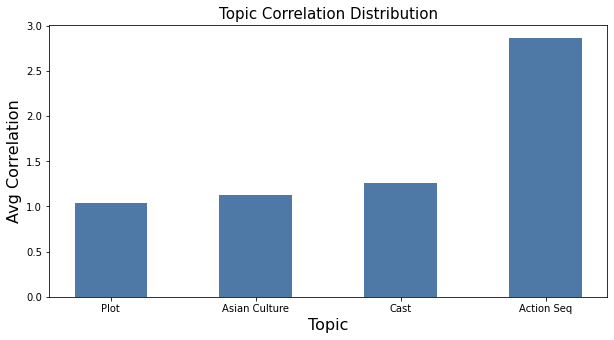

In [114]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_top_model.tcs.shape[0]), sorted(corex_top_model.tcs), color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Avg Correlation', fontsize=16);
plt.xticks(ticks=range(4),labels=['Plot','Asian Culture','Cast','Action Seq'])
plt.title("Topic Correlation Distribution", fontsize='15')

In [29]:
#topics that are most informative about the documents

corex_top_model.log_z

array([[ 2.99259224e+01,  4.62728612e+01,  1.06133296e+02,
         4.22821653e+01],
       [ 1.91447606e+01,  4.39574944e+01,  1.67546211e+02,
         4.58811267e+01],
       [ 1.70068547e+01,  2.18996521e+01,  7.60097145e+01,
         1.82318272e+01],
       ...,
       [ 1.26686259e+00,  1.04593918e+00,  1.92898536e+00,
         1.32673259e+00],
       [ 1.63830804e+00,  1.04599039e+00,  1.92898568e+00,
         8.75793527e-01],
       [-1.27867662e-02,  1.04578784e+00,  1.92898505e+00,
         1.31133806e+00]])

In [30]:
#create topic correlation dataframe

topic_corr=pd.DataFrame(corex_top_model.log_z)



new_series = topic_corr.idxmax(axis=1)
topic_corr['topic']=new_series
topic_corr

,0,1,2,3,topic
0,29.925922,46.272861,106.133296,42.282165,2
1,19.144761,43.957494,167.546211,45.881127,2
2,17.006855,21.899652,76.009715,18.231827,2
3,18.124267,26.278896,81.628482,18.758335,2
4,2.821532,12.760697,48.637745,19.196610,2
...,...,...,...,...,...
2201,1.638308,0.881598,1.928986,1.327120,2
2202,1.628550,1.044426,1.547247,1.324006,0
2203,1.266863,1.045939,1.928985,1.326733,2
2204,1.638308,1.045990,1.928986,0.875794,2


### Sentiment Analysis Corex

In [31]:
#function to get polarity of each review
def get_polarity(string):
    polarity = TextBlob(string).sentiment
    return polarity[0]


new_reviews['polarity']=new_reviews['review'].apply(get_polarity)

new_reviews.head(1)

,review,polarity
0,shang_chi review spectacular visual wonder my ...,0.178936


In [32]:
final_df_corex=new_reviews.merge(topic_corr,left_index=True,right_index=True)
final_df_corex.describe()

,polarity,0,1,2,3,topic
count,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000
mean,0.369056,1.041593,1.130685,2.865981,1.262304,1.600635
std,0.268369,2.255175,3.242228,9.693593,3.414894,0.976169
min,-1.000000,-2.956858,-3.317748,-8.958852,-3.367980,0.000000
25%,0.207143,-0.189387,0.165039,0.719494,0.065468,1.000000
50%,0.375000,1.050493,0.790981,1.561454,0.844183,2.000000
75%,0.550000,1.636754,0.926135,1.928794,1.323716,2.000000
max,1.000000,29.925922,46.272861,167.546211,45.881127,3.000000


In [33]:
def label_polarity(polarity):
    if polarity <= 0:
        return 'neg'
    elif polarity >=.55:
        return'pos'
    else:
        return "neutral"

In [34]:
final_df_corex['pos_neg_neutral']=final_df_corex['polarity'].apply(label_polarity)
final_df_corex.head(1)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
0,shang_chi review spectacular visual wonder my ...,0.178936,29.925922,46.272861,106.133296,42.282165,2,neutral


Text(0.5, 1.0, 'Total Topic Distribution')

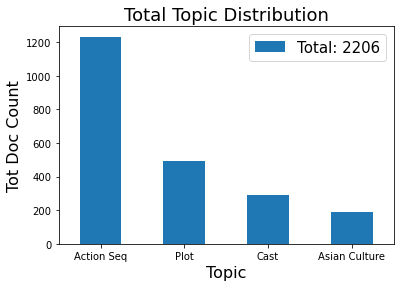

In [95]:
#Topic 0 = story line, fighting scene
#Topic 1 = Asian culture 
#Topic 2 = Martial Arts and Fantasy 
#Topic 3 = Cast i.e awkwafina, simu_liu tony_leung
#find over all distribution of topics
topics = ['Action Seq','Plot','Cast','Asian Culture']
final_df_corex.topic.value_counts().plot(kind='bar')
df_len=len(final_df_corex)
plt.legend([f"Total: {df_len}"], prop={"size":15})

plt.xlabel('Topic', fontsize=16)
plt.ylabel('Tot Doc Count', fontsize=16);
plt.xticks(ticks=np.arange(4),labels=topics,rotation=0)

plt.title('Total Topic Distribution',fontsize='18')

In [96]:
pos_mask = final_df_corex['pos_neg_neutral']=='pos'
neg_mask = final_df_corex['pos_neg_neutral']=='neg'
neutural_mask = final_df_corex['pos_neg_neutral']=='neutral'

Text(0.5, 1.0, 'Topic Distribution (Positive Reviews)')

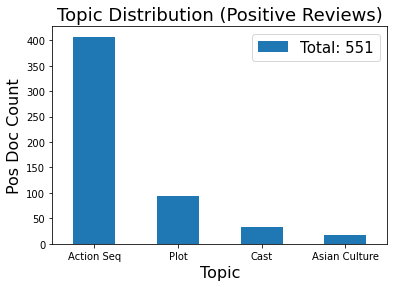

In [97]:
#topic distribution for positive reviews
final_df_corex[pos_mask].topic.value_counts().plot(kind='bar')
pos_len=len(final_df_corex[pos_mask])
plt.legend([f"Total: {pos_len}"], prop={"size":15})
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Pos Doc Count', fontsize=16);


plt.xticks(ticks=np.arange(4),labels=topics,rotation=0)

plt.title('Topic Distribution (Positive Reviews)',fontsize='18')


Text(0.5, 1.0, 'Topic Distribution (Negtive Reviews)')

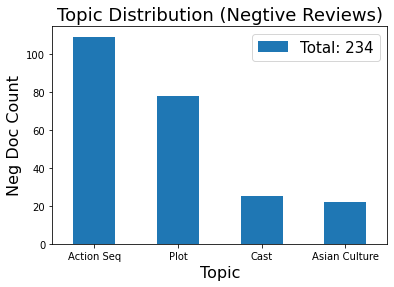

In [98]:
#topic distribution for negative reviews
final_df_corex[neg_mask].topic.value_counts().plot(kind='bar')

neg_len=len(final_df_corex[neg_mask])
plt.legend([f"Total: {neg_len}"], prop={"size":15})
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Neg Doc Count', fontsize=16);

plt.xticks(ticks=np.arange(4),labels=topics,rotation=0)

plt.title('Topic Distribution (Negtive Reviews)',fontsize='18')

Text(0.5, 1.0, 'Topic Distribution (Neutral Reviews)')

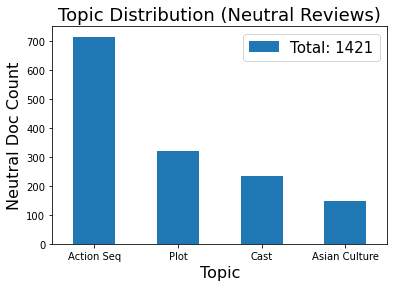

In [99]:
#topic distribution for neutral reviews
final_df_corex[neutural_mask].topic.value_counts().plot(kind='bar')

neut_len=len(final_df_corex[neutural_mask])
plt.legend([f"Total: {neut_len}"], prop={"size":15})
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Neutral Doc Count', fontsize=16);


plt.xticks(ticks=np.arange(4),labels=topics,rotation=0)

plt.title('Topic Distribution (Neutral Reviews)',fontsize='18')

In [40]:
#pull in original reviews

original_reviews=pd.read_csv('shang_chi_reviews.csv')
original_reviews.drop('Unnamed: 0',axis=1,inplace=True)
original_reviews.head()

,review
0,shang chi review spectacular visual wonder m...
1,the much awaited shangi chi and the legend of ...
2,like many i was concerned that this new marve...
3,no movie is without flaws but this was a brea...
4,hands down one of the best mcu movies every a...


In [94]:
#looking at negative reviews

final_df_corex[neg_mask].head()

,review,polarity,0,1,2,3,topic,pos_neg_neutral
82,this movie reveal the very complicated relatio...,-0.029545,-1.103528,15.055646,15.777534,2.377605,2,neg
87,amazing no plot whole quick story development ...,-0.034314,1.976654,0.489978,8.344672,1.325553,2,neg
126,this be I begin to middle and awful the rest o...,-0.041071,-1.127372,0.675029,73.255719,15.499792,2,neg
161,this movie be ruin by racism sterno type with ...,-0.014706,1.278117,9.643561,42.409071,13.939263,2,neg
177,not a strong film in the slight I have very hi...,-0.027653,10.578621,27.139543,65.797514,24.743050,2,neg


In [93]:
#get df of negative topic 1 (asian culture)

neg_top1=final_df_corex[neg_mask][final_df_corex[neg_mask]['topic']==1]
neg_top1.sort_values(1,ascending=False).head(1)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
351,just a non canon you character it seem as if t...,-0.214583,1.266571,16.817912,-0.093472,3.221122,1,neg


In [62]:
#example of negative review about asian culture

original_reviews.review.loc[351]

'just a non canon mcu character   it seems as if the director of crazy rich asians is trying to ensure an asian spotlight  it has failed  the movie is equal to   ronin  which keanu was called a heritage taker  this is a small strike at the grasp of making it  i recommend he sticks to kim s convenience in canada'

In [92]:
#get df of negative topic 0 (plot)

neg_top0=final_df_corex[neg_mask][final_df_corex[neg_mask]['topic']==0]
neg_top0.sort_values(0,ascending=False).head(13)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
2080,hell yeah baby lets go,0.000000,2.322096,1.045015,1.962124,0.076847,0,neg
2103,typical you nothing else but cheapness be over...,-0.166667,2.321509,1.045984,1.211489,1.505697,0,neg
1342,this show never calm out in my country yet but...,-0.150000,1.995352,1.044955,1.149330,1.066643,0,neg
2191,chinese propaganda of hilly ball,-0.050000,1.987583,-0.725048,1.928938,1.322755,0,neg
2011,it s may be get in limb but not interested,-0.125000,1.982837,1.045920,1.929012,1.508937,0,neg
2053,what a movie marvel op,0.000000,1.982837,0.761719,1.928986,1.327302,0,neg
2004,outrageous bad it be difficult to give one star,-0.733333,1.981293,0.466964,1.416395,1.475903,0,neg
1407,truly exhilarate take I back to those jet li move,0.000000,1.980752,1.198457,1.548870,0.703130,0,neg
2164,gooooooooooooooooooooooooooooooooooooooooooooo...,0.000000,1.979756,0.925916,1.928986,1.326895,0,neg
2155,it s like when hernia and milan meat,0.000000,1.979755,1.177293,0.439281,1.321286,0,neg


In [69]:
#example of negative review about topic 0
original_reviews.review.loc[1821]

'worst marvel movie so far  poorly written and badly put together'

In [91]:
#looking at positive reviews top 1(asian culture)

pos_top1=final_df_corex[pos_mask][final_df_corex[pos_mask]['topic']==1]
pos_top1.sort_values(1,ascending=False).head(1)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
318,usually awesome it enlighten a lot about taiwa...,0.551429,-0.149072,9.016102,-1.226878,0.853143,1,pos


In [47]:
#example for positive asian culture review

original_reviews.review.loc[318]

'visually awesome  it enlightens a lot about taiwanese and chinese culture  specially about mythical creatures  which i will not mention to avoid spoilers  fighting music is really smooth and you can tell that they have been perfectly choreographed'

In [90]:
#looking at positive reviews top 0(plot)

pos_top0=final_df_corex[pos_mask][final_df_corex[pos_mask]['topic']==0]
pos_top0.sort_values(0,ascending=False).head(1)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
577,great film excellent cast and act destiny dani...,0.592857,7.212837,1.003568,1.864113,0.695471,0,pos


In [49]:
#example for positive plot review

original_reviews.review.loc[577]

'great film  excellent cast and acting  destin daniel cretton has directed another stunner  special effects were amazing  good story line  too'

In [87]:
#looking at positive for top 3 cast
pos_top3=final_df_corex[pos_mask][final_df_corex[pos_mask]['topic']==3]
pos_top3.sort_values(3,ascending=False).head(1)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
65,if you like marvel move and asia film this be ...,0.610278,-0.780857,-0.658736,3.23401,17.547411,3,pos


In [51]:
#example at positive for top 3 cast
original_reviews.review.loc[65]

'if you like marvel movies and asian films  this is the perfect mix  great cast  great director  simu liu  was perfect for this role  awkwafina was marvelous  everytime i see her movies  i just love her more  great chemistry between the two leads  michelle yeoh  need i say more     fala chen  tony leung chiu wai  benedict    wong  meng  er zhang awesome  awesome  awesome  it brings asian fantasy finally to america  i have always loved asian films  they bring their stories alive with their rich history and mythology  highly recommend the movie  go see it'

In [86]:
#looking at negative for top 3 cast
neg_top3=final_df_corex[neg_mask][final_df_corex[neg_mask]['topic']==3]
neg_top3.sort_values(3,ascending=False).head(3)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
786,it do have some of the you s flaw if you don t...,-0.088611,0.415616,0.262029,-1.132505,9.828128,3,neg
482,the explicit language ruin it for we my or old...,-0.243750,1.202193,-0.513112,1.416359,6.770209,3,neg
451,this be one of the bad marvel production not s...,-0.054545,-0.252969,0.122456,1.867315,6.743016,3,neg


In [118]:
#example at negative for top 3 cast
print(original_reviews.review.loc[451],'\n')
print(original_reviews.review.loc[786])

this is one of the worst marvel productions  not sure why wong needed to be part of the movie   but overall this movie is not worth watching  the initial part of the movie  leading up to the bus fight was quite promising but subsequently was a waste of time  definitely not worth going to the cinema to watch  there were some hilarious scenes here and there but the lack of storyline and loopholes just spoils the whole movie experience  from stealing the jade pendant to installing it on the lion eyes just lack some storyline of how all this came about 

it does have some of the mcu s flaws  if you don t like the mcu you might not like it  unless you re problem is marvels fight coreogrophy  that definitely wasn t an issue        had a hard time deciding what star to round it to  rounded low because i think it s rating is to high


In [89]:
#looking at positive for top 2 Martial arts
pos_top2=final_df_corex[pos_mask][final_df_corex[pos_mask]['topic']==2]
pos_top2.sort_values(2,ascending=False).head(7)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
1899,brilliant movie 👍 max be a must,0.9000,1.639694,0.925625,2.060980,0.548326,2,pos
893,this be one of the most influential move I hav...,0.5500,1.266863,0.925865,2.059075,0.815574,2,pos
2001,amazing 😗 😗 it be soooooooo gooooooooooooooooood,0.6000,1.266863,1.198643,2.059075,1.326733,2,pos
1198,it ' s a fantastic story and truly belong with...,0.6000,-0.508588,0.881250,2.059074,0.181739,2,pos
869,this movie be so amazing and so awesome to wat...,0.5875,-1.026959,0.925773,2.059069,1.062130,2,pos
1641,nice movie but I thing this movie so many income,0.5500,1.637281,0.678304,2.058490,0.526560,2,pos
824,top three good marvel movie fight scene have I...,0.6625,-1.524965,0.759562,1.999163,0.223514,2,pos


In [81]:
#example at positive for top 2 Martial arts
original_reviews.review.loc[824]

'top three best marvel movie  fight scenes have me chills  chemistry was amazing  beautiful'

In [88]:
#looking at negative for top 2
neg_top2=final_df_corex[neg_mask][final_df_corex[neg_mask]['topic']==2]
neg_top2.sort_values(2,ascending=False).head(3)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
126,this be I begin to middle and awful the rest o...,-0.041071,-1.127372,0.675029,73.255719,15.499792,2,neg
177,not a strong film in the slight I have very hi...,-0.027653,10.578621,27.139543,65.797514,24.743050,2,neg
180,this movie be terrible action scene be I jacke...,-0.088670,-0.735461,4.717271,50.365604,7.606885,2,neg


In [85]:
#example at negative for top 2 Martial arts
original_reviews.review.loc[180]

'this movie was terrible  action scenes were meh   jackie chan s worst action scene was better then this   the characters were poorly written  acting itself was a snoozefest   i never even heard of shang chi becasuse i am not a comic book reader but before the movie a did a little bit of reading from the old   s comics  this addaptation of the character was so preverted it s a travasty to the great mcu  what were you guys smoking    or did you not smoke enough     i gave marvel a shot at phase   but  you down played wanda and ruined it for me  you critical race theory falcon which is a shame cause i love anthony mackee  and you killed loki because no matter how great was tom hiddleston you wrote it into the freaking ground  and ofc  black widow was a missed opportunity  bad writing and bad performance     shang chi could have saved it with        i am done wasting money on disney s marvel    not going to watch the eternals or anything else  consider my wallet retired'

In [117]:
final_df_corex[neg_mask].sort_values('polarity',ascending=True)

,review,polarity,0,1,2,3,topic,pos_neg_neutral
2039,this be boring movie I ever watch,-1.000000,1.244634,0.925855,1.928893,1.068884,2,neg
2200,boring story,-1.000000,0.210625,1.045960,1.928893,1.327119,2,neg
2033,the fight scene be insane,-1.000000,-0.890240,1.045800,1.405288,1.326991,2,neg
2102,this be not expect completely disappointed,-0.750000,1.631178,-0.714301,0.976124,1.278471,0,neg
2004,outrageous bad it be difficult to give one star,-0.733333,1.981293,0.466964,1.416395,1.475903,0,neg
...,...,...,...,...,...,...,...,...
1979,didn ' t do it for I aquafina hold it together,0.000000,1.631181,-0.411448,-0.283933,1.320260,0,neg
1983,can t say about the movie just go and watch,0.000000,1.638272,0.925878,1.928986,0.136154,2,neg
2002,see this in lawless victory,0.000000,1.637638,1.197337,1.654451,1.326464,2,neg
1972,this movie be the besttttttttttttttttttttttt,0.000000,1.638308,0.925916,1.928986,1.507269,2,neg
